In [9]:
%run model.ipynb
%run data.ipynb

In [10]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import time
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
x

,酪農場代號_x,胎次_x,泌乳天數,月齡,配種次數,配種方式,精液種類,酪農場代號_y,母牛體重,胎次_y,分娩難易度,酪農場代號,['狀況類別']_1,['狀況類別']_2,['狀況類別']_C,['狀況類別']_D,['狀況類別']_N,['狀況類別']_c,['狀況類別']_n
0,0,1,-0.853582,26,1,0,0,0,-0.477730,1,0.0,0,0,0,0,1,0,0,0
1,0,1,-0.853582,26,1,0,0,0,-0.477730,1,0.0,0,0,0,0,0,1,0,0
2,0,1,-0.853582,26,1,0,0,0,-0.477730,1,0.0,0,0,0,1,0,0,0,0
3,0,1,-0.853582,26,1,0,0,0,-0.477730,2,0.0,0,0,0,0,1,0,0,0
4,0,1,-0.853582,26,1,0,0,0,-0.477730,2,0.0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064239,2,8,0.150803,137,0,0,0,2,2.707923,8,1.0,2,0,0,1,0,0,0,0
1064240,2,8,0.150803,137,0,0,0,2,2.707923,8,1.0,2,0,0,1,0,0,0,0
1064241,2,8,0.150803,137,0,0,0,2,2.707923,8,1.0,2,0,0,1,0,0,0,0
1064242,2,8,0.150803,137,0,0,0,2,2.707923,8,1.0,2,0,0,1,0,0,0,0


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1 ,random_state=1)
len(y_train), len(y_valid)

(957819, 106425)

In [14]:
train_data_tensor = torch.tensor(X_train.values.astype('float32')).float()
train_label_tensor = torch.tensor(y_train).float()
valid_data_tensor = torch.tensor(X_valid.values.astype('float32')).float()
valid_label_tensor = torch.tensor(y_valid).float()
train_data_tensor.shape, train_label_tensor.shape

(torch.Size([957819, 19]), torch.Size([957819]))

In [15]:
batch_size = 32
train_tensor = torch.utils.data.TensorDataset(train_data_tensor, train_label_tensor)
valid_tensor = torch.utils.data.TensorDataset(valid_data_tensor, valid_label_tensor)
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True, pin_memory= True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_tensor, batch_size = batch_size, shuffle = True, pin_memory= True)

In [16]:
Model = model(train_data_tensor.shape[1])
#summary(Model, (batch_size, train_data_tensor.shape[1]), device = "cpu")
Model = Model.to(device)

In [17]:
loss = RMSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr= 0.001)
Epoch = 50

In [18]:
train_loss_list = []
val_loss_list = []
for epoch in range(Epoch):
    since = time.time()
    total_train_loss = 0
    loss_val = 0
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        out = Model(data)
        loss_val = loss(out, label)
        total_train_loss += loss_val
        loss_val.backward()
        optimizer.step()
    for data, label in valid_loader:
        data = data.to(device)
        label = label.to(device)
        out = Model(data)
        loss_val += loss(out,label)
    train_loss_list.append(total_train_loss.item() / len(train_loader))
    val_loss_list.append(loss_val.item() / len(valid_loader))
    now_time = time.time() - since
    print("epoch = ", epoch + 1, " train loss = ", train_loss_list[-1],
    " validation loss = ", val_loss_list[-1])
    print("Training time is:{:.0f}m {:.0f}s".format(now_time // 60, now_time % 60))

epoch =  1  train loss =  13.052398979353201  validation loss =  8.602037568588395
Training time is:2m 32s


KeyboardInterrupt: 

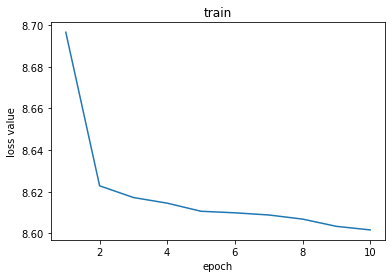

In [10]:
plt.plot(range(1, Epoch + 1), train_loss_list)
plt.title("train")
plt.ylabel("loss value")
plt.xlabel("epoch")
plt.show()

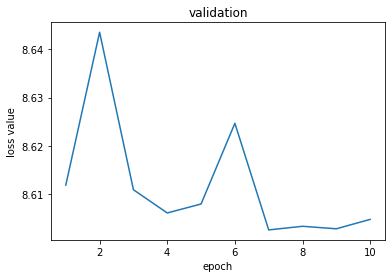

In [11]:
plt.plot(range(1, Epoch + 1), val_loss_list)
plt.title("validation")
plt.ylabel("loss value")
plt.xlabel("epoch")
plt.show()

In [13]:
test_without_ID

,酪農場代號_x,胎次_x,泌乳天數,月齡,配種次數,配種方式,精液種類,酪農場代號_y,母牛體重,胎次_y,分娩難易度,酪農場代號,['狀況類別']_1,['狀況類別']_2,['狀況類別']_C,['狀況類別']_D,['狀況類別']_N,['狀況類別']_c,['狀況類別']_n
0,0,4,1.671192,94,6,0.0,0.0,0.0,-0.447447,1,0.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0,4,1.671192,94,6,0.0,0.0,0.0,-0.447447,2,0.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,4,1.671192,94,6,0.0,0.0,0.0,-0.447447,3,0.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,4,1.671192,94,6,0.0,0.0,0.0,-0.447447,4,0.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,1.671192,94,6,0.0,0.0,0.0,-0.447447,1,0.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75589,2,1,-1.237505,24,0,0.0,0.0,2.0,2.086692,1,1.0,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
75590,2,1,-1.189027,24,0,-1.0,-1.0,-1.0,1.852050,1,1.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75591,2,1,-1.195952,22,0,-1.0,-1.0,-1.0,2.086692,1,1.0,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
75592,2,1,-0.988188,23,0,-1.0,-1.0,-1.0,2.086692,1,1.0,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [15]:
test_data_tensor = torch.tensor(test_without_ID.values.astype('float32')).float()
test_data_tensor.shape

torch.Size([75594, 19])

In [28]:
res = []

In [29]:
for data in test_data_tensor:
    data = data.to(device)
    out = Model(data)
    res.append(out.item())

In [30]:
len(res)

75594

In [31]:
val = pd.DataFrame({'預測乳量':res})
x = test.join(val)
x_group = x.groupby(['ID']).mean()
x_index = list(range(0,x_group.shape[0]))
x_group.index

Int64Index([  480,   742,   743,   744,   745,   793,   794,   800,   801,
              802,
            ...
            37476, 37477, 37478, 37479, 37480, 37481, 37482, 37483, 37484,
            37485],
           dtype='int64', name='ID', length=4263)

Text(0, 0.5, 'predict value')

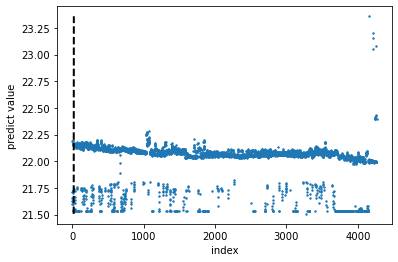

In [32]:
plt.scatter(x_index,x_group['預測乳量'].values,s=2)
plt.plot([x_group['預測乳量'].values.min(), x_group['預測乳量'].values.max()], 
         [x_group['預測乳量'].values.min(),x_group['預測乳量'].values.max()], 'k--', lw=2)
plt.xlabel('index')
plt.ylabel('predict value')

In [33]:
for index in range(x_group.shape[0]):
    submission.loc[index, ['1']] = x_group['預測乳量'].values[index]
submission

,ID,1
0,480,22.187082
1,742,21.707544
2,743,21.656329
3,744,21.624461
4,745,21.598025
...,...,...
4258,37481,21.990763
4259,37482,23.077738
4260,37483,22.435436
4261,37484,22.426104


In [34]:
submission.columns = ['ID','預測乳量']
submission.to_csv('result.csv',index = False)